# Modeling

In [1]:
from function import *

In [2]:
# load data
train = pd.read_csv('data/train_rv.csv')
test = pd.read_csv('data/test_rv.csv')
submission = pd.read_csv('data/sample_submission.csv')

---

### 1. Check VIF 

In [3]:
# check VIF
train_vif = train.drop(['trip_duration'], axis = 1)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(train_vif.values, i) for i in range(train_vif.shape[1])]
vif["features"] = train_vif.columns
vif

,VIF Factor,features
0,1.148465e+01,vendor_id
1,2.841064e+00,passenger_count
2,1.012641e+00,store_and_fwd_flag
3,5.488730e+00,month
4,3.510615e+00,weekday
5,5.578527e+00,hour
6,1.057940e+00,holiday
7,2.887215e+06,pickup_longitude
8,1.886480e+06,pickup_latitude
9,2.710764e+06,dropoff_longitude


In [4]:
# remove high VIF
train = train.drop(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], axis = 1)
test = test.drop(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], axis = 1)

---

### 2. Rough Modeling

In [5]:
# bias ogmantation
train = sm.add_constant(train)
test = sm.add_constant(test)

In [6]:
# regression model
model =  sm.OLS.from_formula('trip_duration ~ vendor_id + passenger_count + store_and_fwd_flag + \
                              month + weekday + hour + holiday + dist', data = train)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          trip_duration   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                 2.403e+05
Date:                Mon, 28 May 2018   Prob (F-statistic):               0.00
Time:                        16:29:38   Log-Likelihood:            -1.1231e+06
No. Observations:             1458638   AIC:                         2.246e+06
Df Residuals:                 1458629   BIC:                         2.246e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              5.1604      0.002   2301.363      0.000       5.156       5.165
vendor_id              0.0171      0.001     18.857      0.000       0.015       0.019
passenger_count        0.0062      0.000     18.165      0.000       0.006       0.007
store_and_fwd_flag    -0.0146      0.006     -2.488      0.013      -0.026      -0.003
month                  0.0131      0.000     50.443      0.000       0.013       0.014
weekday               -0.0164      0.000    -73.500      0.000      -0.017      -0.016
hour                   0.0060   6.79e-05     89.012      0.000       0.006       0.006
holiday               -0.1364      0.003    -48.388      0.000      -0.142      -0.131
dist                   0.9530      0.001   1379.632      0.000       0.952       0.954
==============================================================================
Omnibus:                   373760.964   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         12535739.854
Skew:                           0.571   Prob(JB):                         0.00
Kurtosis:                      17.316   Cond. No.                         215.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

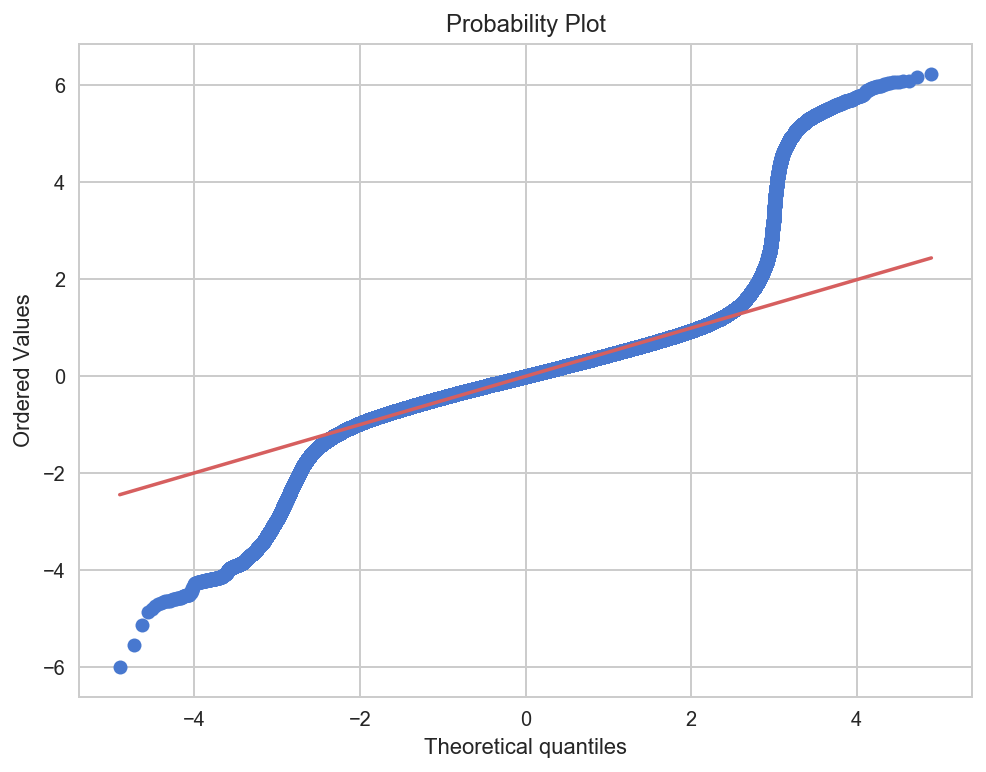

In [7]:
# probplot
f, ax = plt.subplots(figsize=(8, 6))
sp.stats.probplot(result.resid, plot = plt)

plt.show()

In [8]:
# Chi-square 확인
resid = sms.omni_normtest(result.resid)
for i in zip(['Chi^2', 'P-value'], resid):
    print("%-12s: %6.3f" % i)

Chi^2       : 373760.964
P-value     :  0.000


---

### 3. Optimal regulization

In [9]:
# dist scale train
distset1 = dmatrix("scale(np.log1p(dist)) + scale(np.log1p(dist)**2) + scale(np.log1p(dist)**3) \
                 + scale(np.log1p(dist)**4) + scale(np.log1p(dist)**5) + 0", data = train, return_type = 'dataframe')

# columns name 변경
distset1.columns = ['dist1', 'dist2', 'dist3', 'dist4', 'dist5']

In [10]:
# dist scale test
distset2 = dmatrix("scale(np.log1p(dist)) + scale(np.log1p(dist)**2) + scale(np.log1p(dist)**3) \
                 + scale(np.log1p(dist)**4) + scale(np.log1p(dist)**5) + 0", data = test, return_type = 'dataframe')

# columns name 변경
distset2.columns = ['dist1', 'dist2', 'dist3', 'dist4', 'dist5']

In [11]:
# taxi에 distset concat
train = pd.concat([train, distset1], axis=1)
test = pd.concat([test, distset2], axis=1)

In [12]:
train.tail()

,const,vendor_id,passenger_count,store_and_fwd_flag,month,weekday,hour,holiday,dist,trip_duration,dist1,dist2,dist3,dist4,dist5
1458633,1.0,2,4,0,4,4,13,0,0.799447,6.658011,-0.705403,-0.748634,-0.706901,-0.635343,-0.559495
1458634,1.0,1,1,0,1,6,7,0,1.952465,6.486161,1.143658,1.131169,1.023297,0.870649,0.703407
1458635,1.0,2,1,0,4,4,6,0,2.176987,6.639876,1.417352,1.504119,1.470464,1.364599,1.216983
1458636,1.0,1,1,0,1,1,15,0,0.738062,5.924256,-0.835014,-0.838595,-0.761840,-0.666252,-0.575862
1458637,1.0,1,1,0,4,1,14,0,0.757684,5.293305,-0.793092,-0.810097,-0.744799,-0.656867,-0.570999


In [13]:
# dist 
result_sets = pd.DataFrame(columns = ["R-square", "AIC", "BIC", "Cond.No.","Pb(Fstatics)", "Pb(omnibus)", "Pb(jb)", "Dub-Wat","Remarks"])
storage(sm.OLS.from_formula("trip_duration ~ dist", data = train).fit(), result_sets, "dist")
storage(sm.OLS.from_formula("trip_duration ~ dist + I(dist ** 2)", data = train).fit(), result_sets,"~ dist^2")
storage(sm.OLS.from_formula("trip_duration ~ dist + I(dist ** 2) + I(dist ** 3)", data = train).fit(),  result_sets," ~ dist^3")
storage(sm.OLS.from_formula("trip_duration ~ dist + I(dist ** 2) + I(dist ** 3) + I(dist ** 4)", data = train).fit(), result_sets, " ~ dist^4")
storage(sm.OLS.from_formula("trip_duration ~ dist + I(dist ** 2) + I(dist ** 3) + I(dist ** 4) + I(dist ** 5)", data = train).fit(), result_sets, " ~ dist^5")

result_sets

,R-square,AIC,BIC,Cond.No.,Pb(Fstatics),Pb(omnibus),Pb(jb),Dub-Wat,Remarks
0,0.562,2266814.106,2266838.492,4.509,0.0,0.0,0.0,1.998,dist
1,0.591,2169254.770,2169291.349,23.767,0.0,0.0,0.0,1.998,~ dist^2
2,0.594,2157904.502,2157953.274,135.189,0.0,0.0,0.0,1.998,~ dist^3
3,0.594,2156978.938,2157039.904,623.888,0.0,0.0,0.0,1.998,~ dist^4
4,0.595,2155581.482,2155654.640,3864.011,0.0,0.0,0.0,1.998,~ dist^5


In [14]:
# vendor_id
result_sets = pd.DataFrame(columns = ["R-square", "AIC", "BIC", "Cond.No.","Pb(Fstatics)", "Pb(omnibus)", "Pb(jb)", "Dub-Wat","Remarks"])
storage(sm.OLS.from_formula("trip_duration ~ dist1", data = train).fit(), result_sets,"default")
storage(sm.OLS.from_formula("trip_duration ~ vendor_id + dist1", data = train).fit(), result_sets,"vendor_id")
storage(sm.OLS.from_formula("trip_duration ~ C(vendor_id) + dist1", data = train).fit(), result_sets,"C(vendor_id)")
result_sets

,R-square,AIC,BIC,Cond.No.,Pb(Fstatics),Pb(omnibus),Pb(jb),Dub-Wat,Remarks
0,0.592,2164841.136,2164865.522,1.000,0.0,0.0,0.0,1.998,default
1,0.592,2164101.227,2164137.806,7.086,0.0,0.0,0.0,1.998,vendor_id
2,0.592,2164101.227,2164137.806,2.708,0.0,0.0,0.0,1.998,C(vendor_id)


In [15]:
# passengercount
result_sets = pd.DataFrame(columns = ["R-square", "AIC", "BIC", "Cond.No.","Pb(Fstatics)", "Pb(omnibus)", "Pb(jb)", "Dub-Wat","Remarks"])
storage(sm.OLS.from_formula("trip_duration ~ dist1", data = train).fit(), result_sets,"default")
storage(sm.OLS.from_formula("trip_duration ~ passenger_count + dist1", data = train).fit(), result_sets,"passenger_count")
storage(sm.OLS.from_formula("trip_duration ~ C(passenger_count)+dist1", data = train).fit(), result_sets,"C(passenger_count)")
result_sets

,R-square,AIC,BIC,Cond.No.,Pb(Fstatics),Pb(omnibus),Pb(jb),Dub-Wat,Remarks
0,0.592,2164841.136,2164865.522,1.000,0.0,0.0,0.0,1.998,default
1,0.592,2164279.931,2164316.510,3.929,0.0,0.0,0.0,1.998,passenger_count
2,0.592,2163170.925,2163305.048,1551.403,0.0,0.0,0.0,1.998,C(passenger_count)


In [16]:
# store_and_fwd_flag
result_sets = pd.DataFrame(columns = ["R-square", "AIC", "BIC", "Cond.No.","Pb(Fstatics)", "Pb(omnibus)", "Pb(jb)", "Dub-Wat","Remarks"])
storage(sm.OLS.from_formula("trip_duration ~ dist1", data = train).fit(), result_sets,"default")
storage(sm.OLS.from_formula("trip_duration ~ store_and_fwd_flag + dist1", data = train).fit(), result_sets,"store_and_fwd_flag")
storage(sm.OLS.from_formula("trip_duration ~ C(store_and_fwd_flag) + dist1", data = train).fit(), result_sets,"C(store_and_fwd_flag)")
result_sets

,R-square,AIC,BIC,Cond.No.,Pb(Fstatics),Pb(omnibus),Pb(jb),Dub-Wat,Remarks
0,0.592,2164841.136,2164865.522,1.000,0.0,0.0,0.0,1.998,default
1,0.592,2164842.503,2164879.082,13.505,0.0,0.0,0.0,1.998,store_and_fwd_flag
2,0.592,2164842.503,2164879.082,13.505,0.0,0.0,0.0,1.998,C(store_and_fwd_flag)


In [17]:
# month
result_sets = pd.DataFrame(columns = ["R-square", "AIC", "BIC", "Cond.No.","Pb(Fstatics)", "Pb(omnibus)", "Pb(jb)", "Dub-Wat","Remarks"])
storage(sm.OLS.from_formula("trip_duration ~ dist1", data = train).fit(), result_sets,"default")
storage(sm.OLS.from_formula("trip_duration ~ month + dist1", data = train).fit(), result_sets,"store_and_fwd_flag")
storage(sm.OLS.from_formula("trip_duration ~ C(month) + dist1", data = train).fit(), result_sets,"C(store_and_fwd_flag)")
result_sets

,R-square,AIC,BIC,Cond.No.,Pb(Fstatics),Pb(omnibus),Pb(jb),Dub-Wat,Remarks
0,0.592,2164841.136,2164865.522,1.000,0.0,0.0,0.0,1.998,default
1,0.593,2161272.816,2161309.395,9.530,0.0,0.0,0.0,1.998,store_and_fwd_flag
2,0.593,2161133.393,2161218.744,7.033,0.0,0.0,0.0,1.998,C(store_and_fwd_flag)


In [18]:
# weekday
result_sets = pd.DataFrame(columns = ["R-square", "AIC", "BIC", "Cond.No.","Pb(Fstatics)", "Pb(omnibus)", "Pb(jb)", "Dub-Wat","Remarks"])
storage(sm.OLS.from_formula("trip_duration ~ dist1", data = train).fit(), result_sets,"default")
storage(sm.OLS.from_formula("trip_duration ~ weekday + dist1", data = train).fit(), result_sets,"store_and_fwd_flag")
storage(sm.OLS.from_formula("trip_duration ~ C(weekday) + dist1", data = train).fit(), result_sets,"C(store_and_fwd_flag)")
result_sets

,R-square,AIC,BIC,Cond.No.,Pb(Fstatics),Pb(omnibus),Pb(jb),Dub-Wat,Remarks
0,0.592,2164841.136,2164865.522,1.000,0.0,0.0,0.0,1.998,default
1,0.594,2157953.613,2157990.192,7.088,0.0,0.0,0.0,1.998,store_and_fwd_flag
2,0.600,2135767.311,2135864.855,8.265,0.0,0.0,0.0,1.999,C(store_and_fwd_flag)


In [19]:
# weekday
result_sets = pd.DataFrame(columns = ["R-square", "AIC", "BIC", "Cond.No.","Pb(Fstatics)", "Pb(omnibus)", "Pb(jb)", "Dub-Wat","Remarks"])
storage(sm.OLS.from_formula("trip_duration ~ dist1", data = train).fit(), result_sets,"default")
storage(sm.OLS.from_formula("trip_duration ~ weekday + dist1", data = train).fit(), result_sets,"store_and_fwd_flag")
storage(sm.OLS.from_formula("trip_duration ~ C(weekday) + dist1", data = train).fit(), result_sets,"C(store_and_fwd_flag)")
result_sets

,R-square,AIC,BIC,Cond.No.,Pb(Fstatics),Pb(omnibus),Pb(jb),Dub-Wat,Remarks
0,0.592,2164841.136,2164865.522,1.000,0.0,0.0,0.0,1.998,default
1,0.594,2156040.965,2156077.544,35.460,0.0,0.0,0.0,1.998,store_and_fwd_flag
2,0.625,2041393.881,2041698.706,26.863,0.0,0.0,0.0,1.998,C(store_and_fwd_flag)


In [20]:
# holiday
result_sets = pd.DataFrame(columns = ["R-square", "AIC", "BIC", "Cond.No.","Pb(Fstatics)", "Pb(omnibus)", "Pb(jb)", "Dub-Wat","Remarks"])
storage(sm.OLS.from_formula("trip_duration ~ dist1", data = train).fit(), result_sets,"default")
storage(sm.OLS.from_formula("trip_duration ~ holiday + dist1", data = train).fit(), result_sets,"holiday")
storage(sm.OLS.from_formula("trip_duration ~ C(holiday) + dist1", data = train).fit(), result_sets,"C(holiday)")
result_sets

,R-square,AIC,BIC,Cond.No.,Pb(Fstatics),Pb(omnibus),Pb(jb),Dub-Wat,Remarks
0,0.592,2164841.136,2164865.522,1.000,0.0,0.0,0.0,1.998,default
1,0.593,2162459.253,2162495.832,6.418,0.0,0.0,0.0,1.998,holiday
2,0.593,2162459.253,2162495.832,6.418,0.0,0.0,0.0,1.998,C(holiday)


#### Feature Select :

-  dist1 , I(dist1 ** 2) , C(weekday) , C(hour) , C(holiday)

---

### 4. Outlier

#### 4.1 Origin model (0.50021)

In [21]:
# origin data model
model = sm.OLS.from_formula("trip_duration ~ dist1 + I(dist1 ** 2) + C(weekday) + C(hour) + C(holiday) + 0", data = train)
result = model.fit()

In [22]:
# 테스트 데이터를 통해 y값 예측
y_hat = result.predict(test)
y_hat = y_hat.apply(lambda x: (round(np.exp(x))),0)
ans = pd.concat([submission['id'], y_hat], axis=1)
ans.rename(columns={'id':'id' , 0 :'trip_duration'}, inplace=True)
ans.tail()

,id,trip_duration
625129,id3008929,288
625130,id3700764,1062
625131,id2568735,1327
625132,id1384355,2782
625133,id0621643,1025


In [23]:
ans.to_csv('origin.csv', index = False)

#### 4.2 Outlier 1회 (0.49692)

In [24]:
out1 = cooks_distace(result, train)
out1.tail()

,const,vendor_id,passenger_count,store_and_fwd_flag,month,weekday,hour,holiday,dist,trip_duration,dist1,dist2,dist3,dist4,dist5
1407672,1.0,2,4,0,4,4,13,0,0.799447,6.658011,-0.705403,-0.748634,-0.706901,-0.635343,-0.559495
1407673,1.0,1,1,0,1,6,7,0,1.952465,6.486161,1.143658,1.131169,1.023297,0.870649,0.703407
1407674,1.0,2,1,0,4,4,6,0,2.176987,6.639876,1.417352,1.504119,1.470464,1.364599,1.216983
1407675,1.0,1,1,0,1,1,15,0,0.738062,5.924256,-0.835014,-0.838595,-0.761840,-0.666252,-0.575862
1407676,1.0,1,1,0,4,1,14,0,0.757684,5.293305,-0.793092,-0.810097,-0.744799,-0.656867,-0.570999


In [25]:
# Outlier1 data model
model1 = sm.OLS.from_formula("trip_duration ~ dist1 + I(dist1 ** 2) + C(weekday) + C(hour) + 0", data = out1)
result1 = model1.fit()

In [26]:
# 테스트 데이터를 통해 y값 예측
y_hat = result1.predict(test)
y_hat = y_hat.apply(lambda x: (round(np.exp(x))),0)
ans = pd.concat([submission['id'], y_hat], axis=1)
ans.rename(columns={'id':'id' , 0 :'trip_duration'}, inplace=True)
ans.tail()

,id,trip_duration
625129,id3008929,317
625130,id3700764,1190
625131,id2568735,1473
625132,id1384355,2885
625133,id0621643,1150


In [27]:
ans.to_csv('outlier1.csv', index = False)

#### 4.3 Outlier 2회 (0.49563)

In [28]:
out2 = cooks_distace(result1, out1)
out2.tail()

,const,vendor_id,passenger_count,store_and_fwd_flag,month,weekday,hour,holiday,dist,trip_duration,dist1,dist2,dist3,dist4,dist5
1341670,1.0,2,5,0,2,1,0,0,1.198757,6.028279,0.042991,-0.122072,-0.242235,-0.315782,-0.351318
1341671,1.0,2,4,0,4,4,13,0,0.799447,6.658011,-0.705403,-0.748634,-0.706901,-0.635343,-0.559495
1341672,1.0,1,1,0,1,6,7,0,1.952465,6.486161,1.143658,1.131169,1.023297,0.870649,0.703407
1341673,1.0,2,1,0,4,4,6,0,2.176987,6.639876,1.417352,1.504119,1.470464,1.364599,1.216983
1341674,1.0,1,1,0,1,1,15,0,0.738062,5.924256,-0.835014,-0.838595,-0.761840,-0.666252,-0.575862


In [29]:
# Outlier2 data model
model2 = sm.OLS.from_formula("trip_duration ~ dist1 + I(dist1 ** 2) + C(weekday) + C(hour) + 0", data = out2)
result2 = model2.fit()

In [30]:
# 테스트 데이터를 통해 y값 예측
y_hat = result2.predict(test)
y_hat = y_hat.apply(lambda x: (round(np.exp(x))),0)
ans = pd.concat([submission['id'], y_hat], axis=1)
ans.rename(columns={'id':'id' , 0 :'trip_duration'}, inplace=True)
ans.tail()

,id,trip_duration
625129,id3008929,315
625130,id3700764,1191
625131,id2568735,1469
625132,id1384355,2800
625133,id0621643,1152


In [31]:
ans.to_csv('outlier2.csv', index = False)

#### 4.4 Outlier 3회 (0.49563)

In [32]:
out3 = cooks_distace(result2, out2)
out3.tail()

,const,vendor_id,passenger_count,store_and_fwd_flag,month,weekday,hour,holiday,dist,trip_duration,dist1,dist2,dist3,dist4,dist5
1299523,1.0,2,5,0,2,1,0,0,1.198757,6.028279,0.042991,-0.122072,-0.242235,-0.315782,-0.351318
1299524,1.0,2,4,0,4,4,13,0,0.799447,6.658011,-0.705403,-0.748634,-0.706901,-0.635343,-0.559495
1299525,1.0,1,1,0,1,6,7,0,1.952465,6.486161,1.143658,1.131169,1.023297,0.870649,0.703407
1299526,1.0,2,1,0,4,4,6,0,2.176987,6.639876,1.417352,1.504119,1.470464,1.364599,1.216983
1299527,1.0,1,1,0,1,1,15,0,0.738062,5.924256,-0.835014,-0.838595,-0.761840,-0.666252,-0.575862


In [33]:
# Outlier3 data model
model3 = sm.OLS.from_formula("trip_duration ~ dist1 + I(dist1 ** 2) + C(weekday) + C(hour) + 0", data = out2)
result3 = model3.fit()

In [34]:
# 테스트 데이터를 통해 y값 예측
y_hat = result3.predict(test)
y_hat = y_hat.apply(lambda x: (round(np.exp(x))),0)
ans = pd.concat([submission['id'], y_hat], axis=1)
ans.rename(columns={'id':'id' , 0 :'trip_duration'}, inplace=True)
ans.tail()

,id,trip_duration
625129,id3008929,315
625130,id3700764,1191
625131,id2568735,1469
625132,id1384355,2800
625133,id0621643,1152


In [35]:
ans.to_csv('outlier3.csv', index = False)

In [37]:
# 782등
out2.to_csv('data/outlier2.csv')